# Интеллектуальный анализ данных – весна 2022

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [2]:
pk = np.array([0.8, 0.2])
entropy = np.sum(-(pk*np.log2(pk)))
round(entropy,2)

0.72

**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [3]:
middle = np.array([0.8,0.2])
left = 1
right = 1
round(np.sum(middle*(1-middle)) + left*(1-left) + right*(1-right),2)

0.32

**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [4]:
np.mean(np.array([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])) #предсказание это среднее по всем объектам

40.6

## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [5]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.1

In [6]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    def gini(arr):
        val = np.array(list(Counter(arr).values()))
        val = val/np.sum(val)
        return np.sum(val*(1-val))
        
    def variance(arr):
        return np.var(arr)

    ginis = []
    threshold_best = gini_best = None
    values = np.sort(np.unique(feature_vector))
    thresholds = []

    if feature_type == 'real':
        for i in range(1,len(values)):
            threshold = (values[i-1] + values[i]) / 2
            thresholds.append(threshold)
            left = feature_vector < threshold
            right = feature_vector > threshold
            if task == 'classification':
                q = gini(target_vector) - len(target_vector[left])/len(target_vector)*gini(target_vector[left]) - \
                len(target_vector[right])/len(target_vector)*gini(target_vector[right])
            else:
                q = variance(target_vector) - len(target_vector[left])/len(target_vector)*variance(target_vector[left]) - \
                len(target_vector[right])/len(target_vector)*variance(target_vector[right])
            if not gini_best or q > gini_best:
                gini_best = q
                threshold_best = threshold
            ginis.append(q)
    else:
        for i in values:
            thresholds.append(i)
            left = feature_vector == i
            right = feature_vector != i
            if task == 'classification':
                q = gini(target_vector) - len(target_vector[left])/len(target_vector)*gini(target_vector[left]) - \
                len(target_vector[right])/len(target_vector)*gini(target_vector[right])
            else:
                q = variance(target_vector) - len(target_vector[left])/len(target_vector)*variance(target_vector[left]) - \
                len(target_vector[right])/len(target_vector)*variance(target_vector[right])
            if not gini_best or q > gini_best:
                gini_best = q
                threshold_best = i
            ginis.append(q)
    
    return np.array(thresholds),np.array(ginis),threshold_best,gini_best

Эту функцию можно протестировать на датасете `California`.

In [7]:
from sklearn.datasets import fetch_california_housing

In [8]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [9]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

In [10]:
thresholds,ginis,_,_ = find_best_split(feature_vector=X['MedInc'],target_vector=y,feature_type='real',task = 'regression')

Text(0, 0.5, 'Q function')

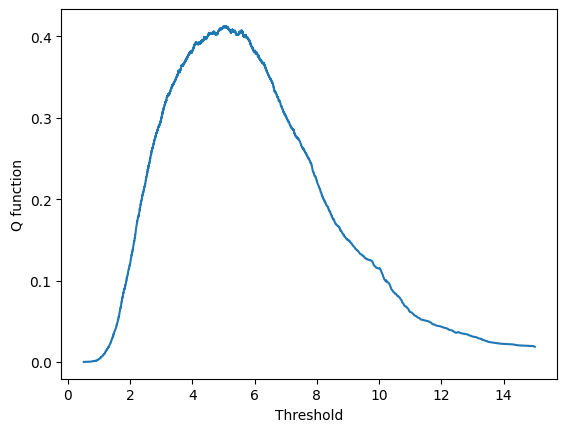

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.lineplot(x=thresholds,y=ginis)
plt.xlabel('Threshold')
plt.ylabel('Q function')

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [12]:
best_pred = best_thres = best_score = None
for i in X.columns:
    _,_,thr,score = find_best_split(feature_vector=X[i],target_vector=y,feature_type='real',task = 'regression')
    print(i,thr,score)
    if not best_score or score > best_score:
        best_score = score
        best_thres = thr
        best_pred = i
# лучший предикат - MedInc c порогом 5.03515 

MedInc 5.03515 0.4127513862016769
HouseAge 51.5 0.030900940598320964
AveRooms 6.374305146225346 0.1592079525892251
AveBedrms 1.1033776245480702 0.015253415595943787
Population 1160.5 0.0028306480479911578
AveOccup 3.1125433206272035 0.07391870577793286
Latitude 37.935 0.09033408765371977
Longitude -121.86500000000001 0.05021105203303022


**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [13]:
class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task
        
        # Переменная, если вы решите делать бонус
        self._feature_importances = {}
        

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        
        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector < threshold
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = feature_vector == threshold
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node['type'] == 'terminal':
            return node['class']
        elif self._feature_types[node['feature_split']] == 'real':
            if x[node['feature_split']] < node['threshold']:
                return self._predict_node(x, node['left_child'])
            else:
                return self._predict_node(x,node['right_child'])
        else:
            if x[node['feature_split']] == node['category_split']:
                return self._predict_node(x,node['left_child'])
            else:
                return self._predict_node(x,node['right_child'])

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

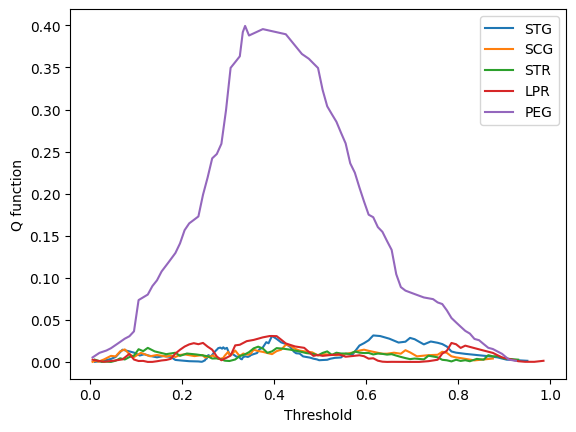

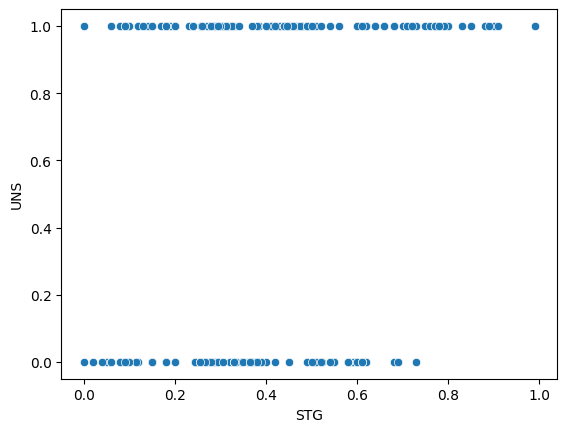

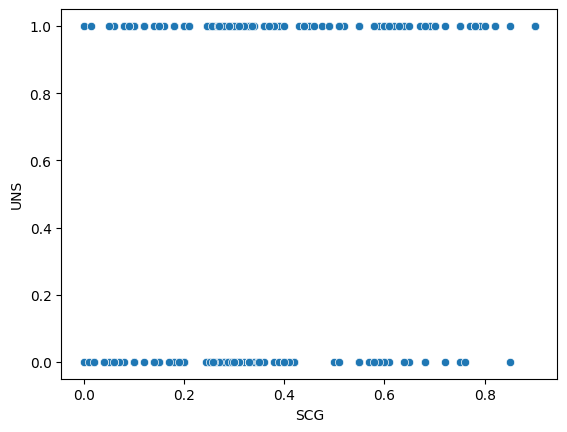

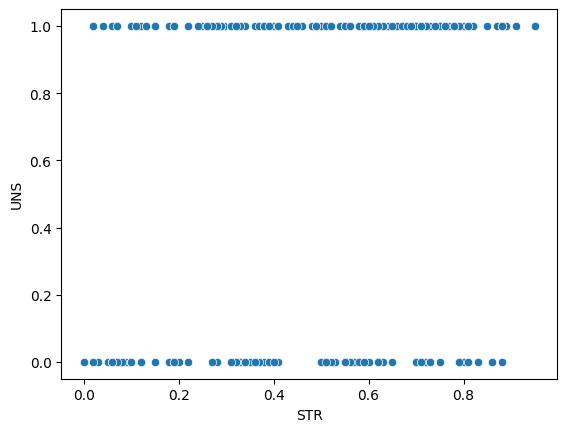

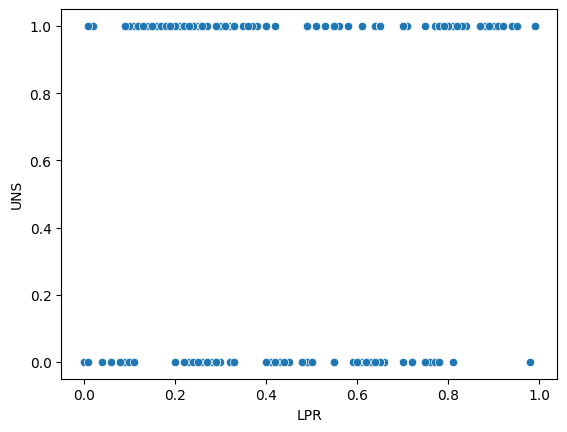

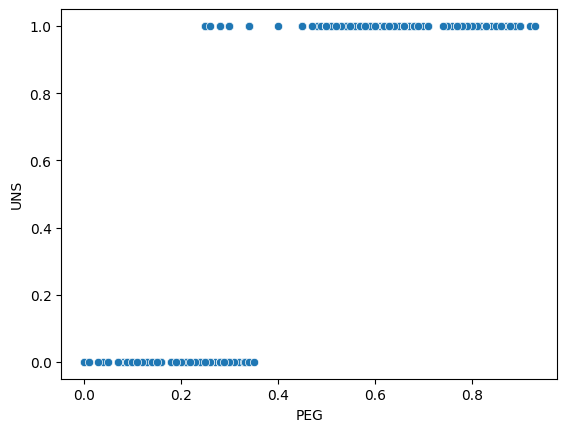

In [14]:
import matplotlib.pyplot as plt
data = pd.read_csv('students.csv')
data = data.drop('Unnamed: 0',axis = 1)
y = data['UNS']
data = data.drop('UNS',axis = 1)
for i in data.columns:
    thr,gini,_,_ = find_best_split(feature_vector=data[i],target_vector=y,feature_type='real',task = 'classification')
    sns.lineplot(x = thr,y = gini,label = i)
plt.xlabel('Threshold')
plt.ylabel('Q function')
plt.show()

for i in data.columns:
    sns.scatterplot(data = data,x = i, y = y)
    plt.show()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

Согласно функционалу качества - он принимает наибольшое значение при разбиении по признаку 'PEG'. Если рассматривать значения классов\значения признаков, то можно увидеть, что для признака 'PEG' просматривается практически идеальное разделение классов. Для остальных же признаков - просматривается практически равномерное распределение значения признака\класа целевой переменной.

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [15]:
from sklearn.preprocessing import LabelEncoder
data = pd.read_csv('agaricus-lepiota.data',header=None)
y = data[0]
data = data.drop(0,axis = 1)
data

,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,22
0,x,s,n,t,p,f,c,n,k,e,...,s,w,w,p,w,o,p,k,s,u
1,x,s,y,t,a,f,c,b,k,e,...,s,w,w,p,w,o,p,n,n,g
2,b,s,w,t,l,f,c,b,n,e,...,s,w,w,p,w,o,p,n,n,m
3,x,y,w,t,p,f,c,n,n,e,...,s,w,w,p,w,o,p,k,s,u
4,x,s,g,f,n,f,w,b,k,t,...,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,k,s,n,f,n,a,c,b,y,e,...,s,o,o,p,o,o,p,b,c,l
8120,x,s,n,f,n,a,c,b,y,e,...,s,o,o,p,n,o,p,b,v,l
8121,f,s,n,f,n,a,c,b,n,e,...,s,o,o,p,o,o,p,b,c,l
8122,k,y,n,f,y,f,c,n,b,t,...,k,w,w,p,w,o,e,w,v,l


In [16]:
encoder = LabelEncoder()
for i in data.columns:
    data[i] = encoder.fit_transform(data[i])
data

,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,22
0,5,2,4,1,6,1,0,1,4,0,...,2,7,7,0,2,1,4,2,3,5
1,5,2,9,1,0,1,0,0,4,0,...,2,7,7,0,2,1,4,3,2,1
2,0,2,8,1,3,1,0,0,5,0,...,2,7,7,0,2,1,4,3,2,3
3,5,3,8,1,6,1,0,1,5,0,...,2,7,7,0,2,1,4,2,3,5
4,5,2,3,0,5,1,1,0,4,1,...,2,7,7,0,2,1,0,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,3,2,4,0,5,0,0,0,11,0,...,2,5,5,0,1,1,4,0,1,2
8120,5,2,4,0,5,0,0,0,11,0,...,2,5,5,0,0,1,4,0,4,2
8121,2,2,4,0,5,0,0,0,5,0,...,2,5,5,0,1,1,4,0,1,2
8122,3,3,4,0,8,1,0,1,0,1,...,1,7,7,0,2,1,0,7,4,2


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
x_tr,x_test,y_tr,y_test = train_test_split(data,y,test_size=0.5)
model = DecisionTree(feature_types=['categorical']*x_tr.shape[1])
model.fit(x_tr.values,y_tr.values)

In [20]:
accuracy_score(y_test,model.predict(x_test.values))

1.0

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [21]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [22]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

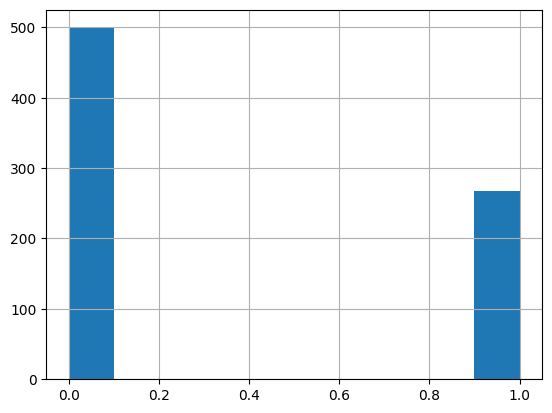

In [23]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [24]:
x_tr_val,x_test,y_tr_val,y_test = train_test_split(data.drop('Outcome',axis=1),data['Outcome'],test_size=0.3)
x_tr,x_val,y_tr,y_val = train_test_split(x_tr_val,y_tr_val,train_size=0.7)

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [160]:
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score,roc_auc_score
depth = [2,3,4,5,6,7]
samples = [1,2,3,5,10,15]
best_quality = None
best_params = [samples[0],depth[0]]
for i in samples:
    for j in depth:
        clf = DecisionTreeClassifier(max_depth=j,min_samples_leaf=i)
        clf.fit(x_tr,y_tr)
        if not best_quality or f1_score(clf.predict(x_val),y_val) > best_quality:
            best_quality = f1_score(clf.predict(x_val),y_val)
            best_params = [i,j]

print(best_params,'best depth, best min_samples_leaf')
clf = DecisionTreeClassifier(min_samples_leaf=best_params[0],max_depth=best_params[1])
clf.fit(x_tr_val,y_tr_val)
print(accuracy_score(y_test,clf.predict(x_test)),'Accuracy',precision_score(y_test,clf.predict(x_test)),'Precision',
recall_score(y_test,clf.predict(x_test)),'Recall',roc_auc_score(y_test,clf.predict(x_test)),'ROC-AUC')

[5, 5] best depth, best min_samples_leaf
0.7359307359307359 Accuracy 0.6021505376344086 Precision 0.7 Recall 0.7274834437086092 ROC-AUC


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [162]:
clf_bag = BaggingClassifier(n_estimators=50)
clf_bag.fit(x_tr_val,y_tr_val)
print(accuracy_score(y_test,clf_bag.predict(x_test)),'Accuracy',precision_score(y_test,clf_bag.predict(x_test)),'Precision',
recall_score(y_test,clf_bag.predict(x_test)),'Recall',roc_auc_score(y_test,clf_bag.predict(x_test)),'ROC-AUC')

0.7705627705627706 Accuracy 0.6708860759493671 Precision 0.6625 Recall 0.745157284768212 ROC-AUC


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [163]:
from sklearn.model_selection import cross_val_score
samples = [2,3,4,5,8,10,15,20]
depth = [1,2,3,4,5,6,7,8]
best_quality = None
best_params = [samples[0],depth[0]]
for i in samples:
    for j in depth:
        clf_forest = RandomForestClassifier(n_estimators=50,max_depth=j,min_samples_split=i)
        values = cross_val_score(clf_forest,x_tr_val,y_tr_val,cv = 10,scoring='f1')
        if not best_quality or values.mean() > best_quality:
            best_quality = values.mean()
            best_params = [i,j]
            
print(best_params,'best depth, best min_samples_split')
clf_forest = RandomForestClassifier(n_estimators=50,min_samples_split=best_params[0],max_depth=best_params[1])
clf_forest.fit(x_tr_val,y_tr_val)
print(accuracy_score(y_test,clf_forest.predict(x_test)),'Accuracy',precision_score(y_test,clf_forest.predict(x_test)),'Precision',
recall_score(y_test,clf_forest.predict(x_test)),'Recall',roc_auc_score(y_test,clf_forest.predict(x_test)),'ROC-AUC')

[8, 8] best depth, best min_samples_split
0.7748917748917749 Accuracy 0.6944444444444444 Precision 0.625 Recall 0.7396523178807948 ROC-AUC


C точки зрения accuracy_score,precision лучше себя показала модель RandomForest. С точки зрения recall - DecisionTreeClassifier. В общем, на основании ROC-AUC - лучше всего себя показала модель BaggingClassifier.

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

[0.6362996688741722, 0.5959023178807947, 0.6712334437086093, 0.6492135761589404, 0.717591059602649, 0.7047185430463576, 0.7135347682119205, 0.725662251655629, 0.7459023178807948, 0.7330298013245033, 0.745157284768212, 0.745157284768212]


<BarContainer object of 12 artists>

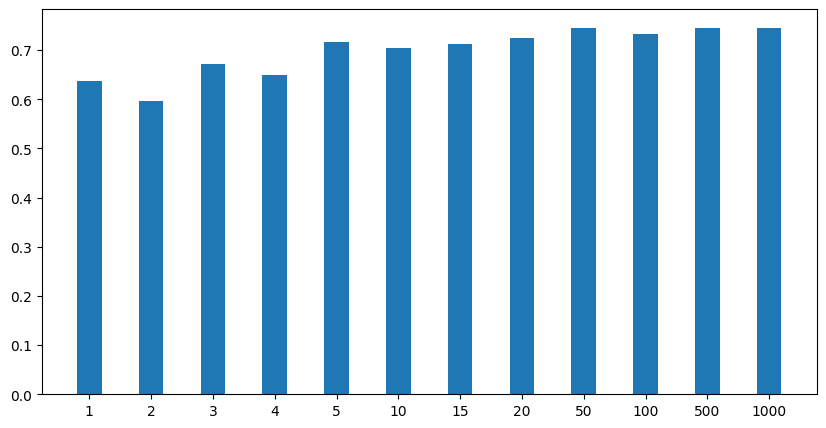

In [164]:
estimators = [1,2,3,4,5,10,15,20,50,100,500,1000]
score = []
for i in estimators:
    clf_forest = RandomForestClassifier(n_estimators=i)
    clf_forest.fit(x_tr_val,y_tr_val)
    score.append(roc_auc_score(y_test,clf_forest.predict(x_test)))
print(score)
fig = plt.figure(figsize = (10, 5))
   
plt.bar([str(i) for i in estimators],score,width=0.4)

Можно сделать вывод, что после 50 деревьев качество практически не изменяется, остается на 1ом уровне. Т.е. количество деревьев после определенной отметки не дают значимого прироста качества модели

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

<BarContainer object of 8 artists>

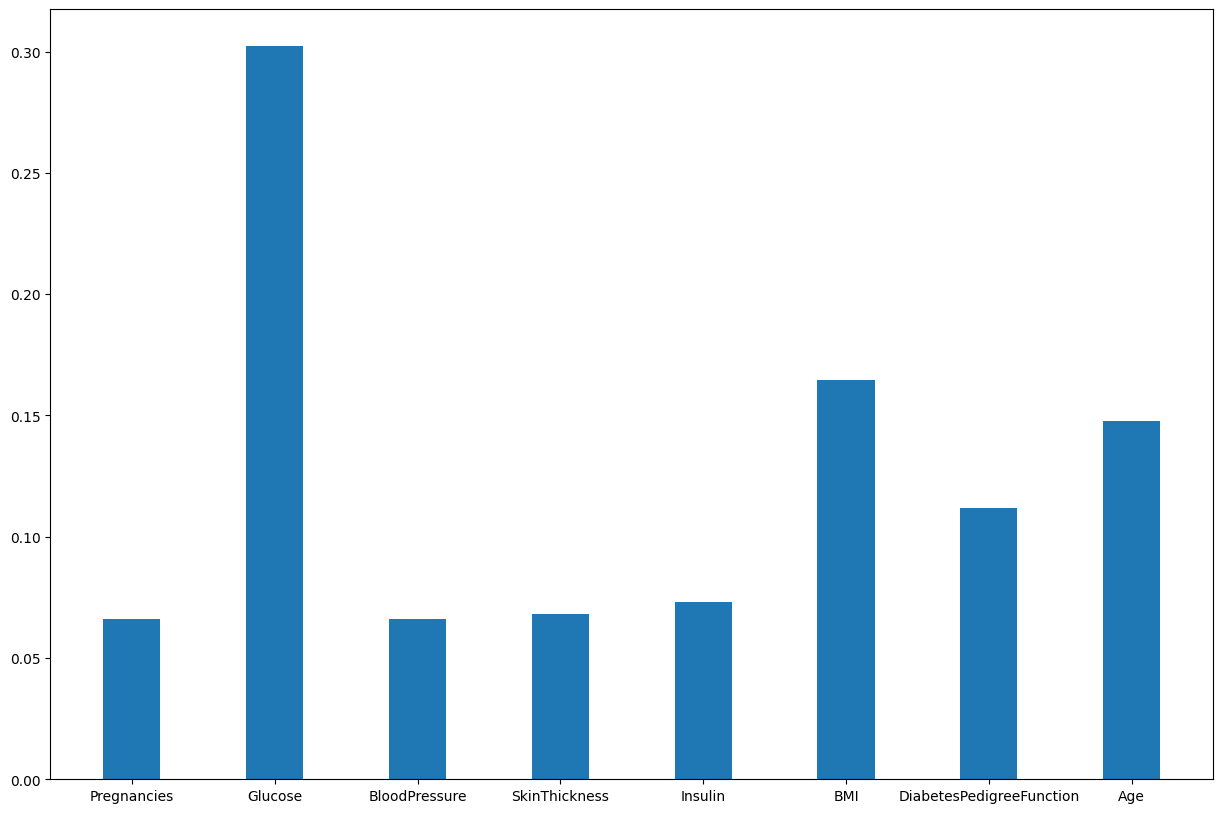

In [22]:
clf_forest = RandomForestClassifier(n_estimators=50,min_samples_split=best_params[0],max_depth=best_params[1])
clf_forest.fit(x_tr_val,y_tr_val)
features_importance = clf_forest.feature_importances_
fig = plt.figure(figsize = (15, 10))

plt.bar(clf_forest.feature_names_in_,features_importance,width=0.4) #Уровень глюкозы самый важный